Import all package

In [78]:
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yfin
import sqlite3 as sql
import pandas as pd
import pandas_datareader as pdr
import threading
import time
import os

Tickers

In [4]:
currencies = ["BTC-USD","ETH-USD","TTE.PA","ROK3.L","PREM.L"]

Ticker Getter

In [87]:
def getMetaData(s : str):
    ticker = yfin.Ticker(s)
    ticker.history()
    meta = ticker.history_metadata
    return meta

def getHistoryData(s : str):
    ticker = yfin.Ticker(s)
    data = ticker.history("max", interval = '1d')
    data['Date'] = data.index
    data = data[["Date", "Open", "High","Low", "Close", "Volume"]]
    data.reset_index(drop=True, inplace=True)
    return data

def getHistoryDataPeriod(s : str , period : str):
    ticker = yfin.Ticker(s)
    data = ticker.history(period = period ,interval = '1d')
    data['Date'] = data.index
    data = data[["Date", "Open", "High","Low", "Close", "Volume"]]
    data.reset_index(drop=True, inplace=True)
    return data

def getCurrentData(tickers :list):
    return pdr.get_quote_yahoo(tickers)["regularMarketPrice"]

Currency Table with meta data

In [4]:
def createCurrencyTable():
    db = sql.connect("mydatabase.db")
    c = db.cursor()
    dropCurrencyTable = '''DROP TABLE IF EXISTS currency'''

    createCurrencyTable = '''CREATE TABLE currency(
        [currencyId] INTEGER PRIMARY KEY AUTOINCREMENT,
        [currencyName] TEXT,
        [instrumentType] TEXT,
        [regularMarketTime] INT,
        [gtmOffset] INT,
        [timezone] TEXT
        )'''
    c.execute(dropCurrencyTable)
    c.execute(createCurrencyTable)
    db.commit()

def insertMultipleCurrency(currencies : list):
    db = sql.connect("mydatabase.db")
    c = db.cursor()
    request = '''INSERT INTO currency (currencyName,instrumenttype,regularMarketTime,gtmOffset,timezone)
        VALUES  '''
    for curr in currencies:
        metaData = getMetaData(curr)
        request += f'''
        ('{metaData['symbol']}',
        '{metaData['instrumentType']}',
        {metaData['regularMarketTime']},
        {metaData['gmtoffset']},
        '{metaData['timezone']}')'''
        if not curr == currencies[-1]:
            request += ','
        else:
            request += ';'
    
    c.execute(request)
    db.commit()

def insertSingleCurrency(currency : str):
    db = sql.connect("mydatabase.db")
    c = db.cursor()
    metaData = getMetaData(currency)
    request = f'''INSERT INTO currency (currencyName,instrumenttype,regularMarketTime,gtmOffset,timezone)
        VALUES ('{metaData['symbol']}' , '{metaData['instrumentType']}', {metaData['regularMarketTime']} , {metaData['gmtoffset']}, '{metaData['timezone']}')'''
    c.execute(request)
    db.commit()



Market Table

In [69]:
def cleanNameForSQL(s :str):
    for char in ['-','.','^']:
            s = s.replace(char,"")
    return s

def createMultipleTableMarket(currencies):
    db = sql.connect("mydatabase.db")
    c = db.cursor()
    for curr in currencies:
        tableName = cleanNameForSQL(curr)
        createNewCurrencyTable = f'''CREATE TABLE IF NOT EXISTS {tableName}_MARKET 
        ([Id] INTEGER PRIMARY KEY AUTOINCREMENT,
        [Date] TEXT,
        [OPEN] NUMBER,
        [HIGH] NUMBER,
        [LOW] NUMBER,
        [Close] NUMBER,
        [Volume] NUMBER)'''
        c.execute(createNewCurrencyTable)
    db.commit()

def createFillTableRequest(currency : str, tableName : str):
    request = f'''INSERT INTO {tableName}_MARKET (Date,Open,High,Low,Close,Volume)
        VALUES  '''
    data = getHistoryData(currency)
    for i in range(data):
        line = data.iloc[i]
        round(line[2:5],13)
        request += f'''('{line['Date']}',{line['Open']},{line['Hight']},{line['Low']}{round(line['Close'],13)},{line['Volume']})'''
        if not (i == data.shape[0]-1):
            request += ','
        else:
            request += ';'
    return request

def fillAllTable(currencies : list):
    db = sql.connect("mydatabase.db")
    c = db.cursor()
    for curr in currencies:
        tableName = str(curr)
        for char in ['-','.','^']:
            tableName = tableName.replace(char,"")
        request = createFillTableRequest(curr , tableName)
        c.execute(request)
    db.commit()

General DB Function

In [6]:
def resetDb(currencies):
    os.remove("mydatabase.db")
    createCurrencyTable()
    insertMultipleCurrency(currencies)
    createMultipleTableMarket(currencies)

def setDb(currencies):
    createCurrencyTable()
    insertMultipleCurrency(currencies)
    createMultipleTableMarket(currencies)

setDb(currencies)

Thread get current price

In [70]:
class thread(threading.Thread):
    def __init__(self, threadName , threadTicker):
        threading.Thread.__init__(self)
        self.threadName = threadName
        self.threadTicker = threadTicker
        self.i = 0
        self.killed = False
    
    def run(self):
        print("-------Start Thread--------")
        lastTime = time.time().__int__()
        values = getCurrentData(self.threadTicker)
        print(f'''Value {self.i} : {values.index[0]} , {values[0]}''')
        self.i = 0
        while True and not self.killed:
            currentTime = time.time().__int__() 
            if currentTime == lastTime + 10:
                self.i +=1
                lastTime = currentTime
                values = getCurrentData(self.threadTicker)
                print(f'''Value {self.i} : {values.index[0]} , {values[0]}''')
            if self.i == 10:
                print("-------End Thread--------")
                break
            time.sleep(1)
        return None

    def kill(self):
        self.killed = True
        print("-------Thread Killed---------")

# threadApi = thread("getDataThread","TTE.PA")
# threadApi.start()
# threadApi.join()

Display stock chart

[*********************100%***********************]  1 of 1 completed


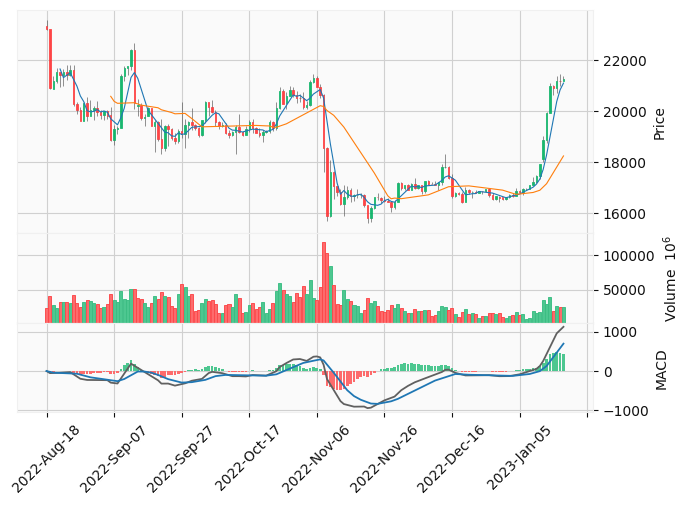

In [117]:
import mplfinance as mpf

def displayStockChart(s : str):
    data = yfin.download(s,period='5mo')

    # Add MACD as subplot
    def MACD(data, window_slow, window_fast, window_signal):
        macd = pd.DataFrame()
        macd['ema_slow'] = data['Close'].ewm(span=window_slow).mean()
        macd['ema_fast'] = data['Close'].ewm(span=window_fast).mean()
        macd['macd'] = macd['ema_slow'] - macd['ema_fast']
        macd['signal'] = macd['macd'].ewm(span=window_signal).mean()
        macd['diff'] = macd['macd'] - macd['signal']
        macd['bar_positive'] = macd['diff'].map(lambda x: x if x > 0 else 0)
        macd['bar_negative'] = macd['diff'].map(lambda x: x if x < 0 else 0)
        return macd

    macd = MACD(data, 12, 26, 9)
    macd_plot  = [
        mpf.make_addplot((macd['macd']), color='#606060', panel=2, ylabel='MACD', secondary_y=False),
        mpf.make_addplot((macd['signal']), color='#1f77b4', panel=2, secondary_y=False),
        mpf.make_addplot((macd['bar_positive']), type='bar', color='#4dc790', panel=2),
        mpf.make_addplot((macd['bar_negative']), type='bar', color='#fd6b6c', panel=2),
    ]


    mpf.plot(data, type='candle', style='yahoo', mav=(5,20), volume=True, addplot=macd_plot)

displayStockChart("BTC-USD")